In [7]:
import os
import pandas as pd
import torch
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class CustomImageDataset(Dataset):
    def __init__(self, annotation_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotation_file, header=None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        slicer = slice(-9)
        img_path1 = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0][slicer], self.img_labels.iloc[idx, 0])
        img_path2 = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1][slicer], self.img_labels.iloc[idx, 1])
        image1 = read_image(img_path1)
        image2 = read_image(img_path2)
        label = self.img_labels.iloc[idx, 2]
        
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        if self.target_transform:
            label = self.target_transform(image1)
        #return image1, image2, label, img_path1, img_path2        
        return image1, image2, label

path_trainSet = f"/Users/necatiisik/lfw_dataset/pairsDevTrain.txt"
path_testSet = f"/Users/necatiisik/lfw_dataset/pairsDevTest.txt"

datasetPath = f"/Users/necatiisik/lfw_dataset/lfw/"
trainLabelPath = f"/Users/necatiisik/lfw_dataset/pair_train_data.csv"
testLabelPath = f"/Users/necatiisik/lfw_dataset/pair_test_data.csv"


preprocess = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize(size=140),  # Conver 140x140 input images
  transforms.ToTensor()
#   transforms.Normalize(
#       mean=[0.6071, 0.4609, 0.3944],  # Normalization settings for the model, the calculated mean and std values
#       std=[0.2457, 0.2175, 0.2129]     # for the RGB channels of the tightly-cropped glint360k face dataset
#   )
])

train_data = CustomImageDataset(trainLabelPath, datasetPath, transform=preprocess, target_transform=None)
test_data = CustomImageDataset(testLabelPath, datasetPath, transform=preprocess, target_transform=None)

batch_size = 64

train_loader = DataLoader(dataset = train_data,
                          batch_size = batch_size, 
                          shuffle = True)

test_loader = DataLoader(dataset = test_data,
                         batch_size = batch_size, 
                         shuffle = True)

In [3]:
from __future__ import print_function
import argparse, random, copy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR


class SiameseNetwork(nn.Module):
    """
        Siamese network for image similarity estimation.
        The network is composed of two identical networks, one for each input.
        The output of each network is concatenated and passed to a linear layer. 
        The output of the linear layer passed through a sigmoid function.
        `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
        This implementation varies from FaceNet as we use the `ResNet-18` model from
        `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
        In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(pretrained=False)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        # overruled.. get (3,x,x)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.fc_in_features = self.resnet.fc.in_features
        
        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features
        output = torch.cat((output1, output2), 1)

        # pass the concatenation to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)
        
        return output

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    for batch_idx, (images_1, images_2, targets) in enumerate(train_loader):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device, torch.float32)
        optimizer.zero_grad()
        outputs = model(images_1, images_2).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if batch_idx % 2 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images_1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    return loss.item()
            # if args.dry_run:
            #     break

In [5]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    # we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    criterion = nn.BCELoss()

    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device, torch.float32)
            outputs = model(images_1, images_2).squeeze()
            test_loss += criterion(outputs, targets).sum().item()  # sum up batch loss
            pred = torch.where(outputs > 0.5, 1, 0)  # get the index of the max log-probability
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # for the 1st epoch, the average loss is 0.0001 and the accuracy 97-98%
    # using default settings. After completing the 10th epoch, the average
    # loss is 0.0000 and the accuracy 99.5-100% using default settings.
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss

/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/yg/vjnq2s395_5652ng6cshx95h0000gn/T/ipykernel_2503/3421993037.py:57: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


Train Epoch: 0 [0/2200 (0%)]	Loss: 0.765422
Train Epoch: 0 [128/2200 (6%)]	Loss: 1.627343
Train Epoch: 0 [256/2200 (11%)]	Loss: 0.840582
Train Epoch: 0 [384/2200 (17%)]	Loss: 0.873091
Train Epoch: 0 [512/2200 (23%)]	Loss: 0.848163
Train Epoch: 0 [640/2200 (29%)]	Loss: 0.797476
Train Epoch: 0 [768/2200 (34%)]	Loss: 0.659293
Train Epoch: 0 [896/2200 (40%)]	Loss: 0.707355
Train Epoch: 0 [1024/2200 (46%)]	Loss: 0.747391
Train Epoch: 0 [1152/2200 (51%)]	Loss: 0.704569
Train Epoch: 0 [1280/2200 (57%)]	Loss: 0.666723
Train Epoch: 0 [1408/2200 (63%)]	Loss: 0.740863
Train Epoch: 0 [1536/2200 (69%)]	Loss: 0.693360
Train Epoch: 0 [1664/2200 (74%)]	Loss: 0.715588
Train Epoch: 0 [1792/2200 (80%)]	Loss: 0.684295
Train Epoch: 0 [1920/2200 (86%)]	Loss: 0.731940
Train Epoch: 0 [2048/2200 (91%)]	Loss: 0.748995
Train Epoch: 0 [816/2200 (97%)]	Loss: 0.755383

Test set: Average loss: 0.0125, Accuracy: 500/1000 (50%)



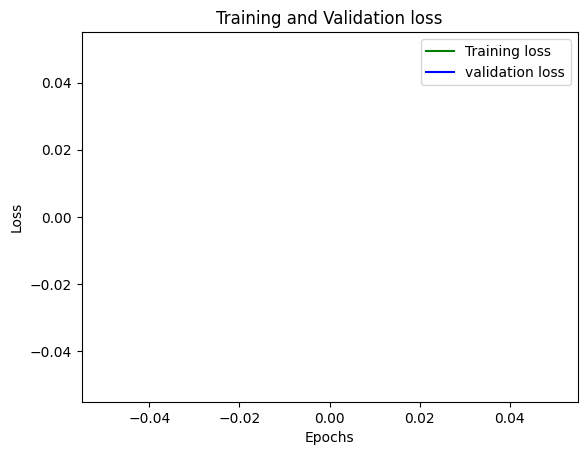

Train Epoch: 1 [0/2200 (0%)]	Loss: 0.772907
Train Epoch: 1 [128/2200 (6%)]	Loss: 0.756566
Train Epoch: 1 [256/2200 (11%)]	Loss: 0.690289
Train Epoch: 1 [384/2200 (17%)]	Loss: 0.672591
Train Epoch: 1 [512/2200 (23%)]	Loss: 0.695151
Train Epoch: 1 [640/2200 (29%)]	Loss: 0.699965
Train Epoch: 1 [768/2200 (34%)]	Loss: 0.686148
Train Epoch: 1 [896/2200 (40%)]	Loss: 0.678851
Train Epoch: 1 [1024/2200 (46%)]	Loss: 0.745533
Train Epoch: 1 [1152/2200 (51%)]	Loss: 0.678513
Train Epoch: 1 [1280/2200 (57%)]	Loss: 0.691073
Train Epoch: 1 [1408/2200 (63%)]	Loss: 0.703144
Train Epoch: 1 [1536/2200 (69%)]	Loss: 0.719995
Train Epoch: 1 [1664/2200 (74%)]	Loss: 0.696875
Train Epoch: 1 [1792/2200 (80%)]	Loss: 0.692295
Train Epoch: 1 [1920/2200 (86%)]	Loss: 0.703044
Train Epoch: 1 [2048/2200 (91%)]	Loss: 0.697297
Train Epoch: 1 [816/2200 (97%)]	Loss: 0.650299

Test set: Average loss: 0.0111, Accuracy: 546/1000 (55%)



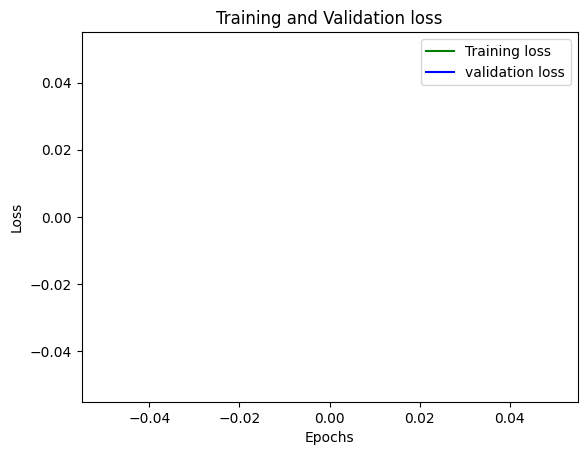

Train Epoch: 2 [0/2200 (0%)]	Loss: 0.693741
Train Epoch: 2 [128/2200 (6%)]	Loss: 0.720167
Train Epoch: 2 [256/2200 (11%)]	Loss: 0.699237
Train Epoch: 2 [384/2200 (17%)]	Loss: 0.681419
Train Epoch: 2 [512/2200 (23%)]	Loss: 0.686853
Train Epoch: 2 [640/2200 (29%)]	Loss: 0.710564
Train Epoch: 2 [768/2200 (34%)]	Loss: 0.694289
Train Epoch: 2 [896/2200 (40%)]	Loss: 0.687360
Train Epoch: 2 [1024/2200 (46%)]	Loss: 0.698357
Train Epoch: 2 [1152/2200 (51%)]	Loss: 0.693986
Train Epoch: 2 [1280/2200 (57%)]	Loss: 0.683421
Train Epoch: 2 [1408/2200 (63%)]	Loss: 0.710881
Train Epoch: 2 [1536/2200 (69%)]	Loss: 0.720690
Train Epoch: 2 [1664/2200 (74%)]	Loss: 0.664530
Train Epoch: 2 [1792/2200 (80%)]	Loss: 0.696110


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt

model = SiameseNetwork().to(device)
# model.load_state_dict(torch.load("siamese_network_resnet_A-S-A-S.pt"))
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

lossTrain = []
lossTest = []
epochs = []

tot_epoch  = 10
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(tot_epoch):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss = test(model, device, test_loader)
    scheduler.step()
    lossTrain.append(train_loss)
    lossTest.append(test_loss)
    epochs.append(epoch)

    plt.plot(epochs, lossTrain, 'g', label='Training loss')
    plt.plot(epochs, lossTest, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



    

torch.save(model.state_dict(), "siamese_network.pt")

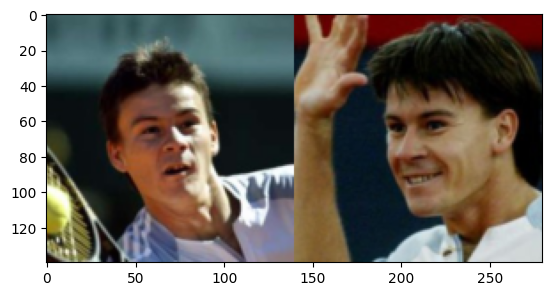

1st image: Guillermo_Coria_0019.jpg -- 2nd image: Guillermo_Coria_0029.jpg
Label of the data: 1 (1: Same, 0: Not)


In [39]:
import torch
import numpy as np
import matplotlib.pyplot as plt

image1, image2, train_labels, path1, path2 = next(iter(train_loader))
# print(f"Feature batch shape: {image1.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
img1 = image1[0].squeeze()
img1 = img1.movedim(0, -1)
img2 = image2[0].squeeze()
img2 = img2.movedim(0, -1)
img1 = torch.cat((img1, img2), 1)

label = train_labels[0]
plt.imshow(img1)
plt.show()
first_image_label = path1[0].split("/")[6]
second_image_label = path2[0].split("/")[6]

print(f"1st image: {first_image_label} -- 2nd image: {second_image_label}")
print(f"Label of the data: {label} (1: Same, 0: Not)")


# model.eval()

# with torch.no_grad():
#     outputs = model(img1[0], img2[0]).squeeze()
#     pred = torch.where(outputs > 0.5, 1, 0)

# print(f"Prediction of the network: {pred} (1: Same, 0: Not)")



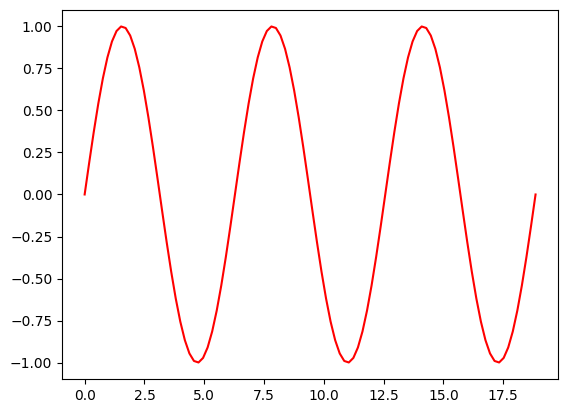

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 6*np.pi, 100)
y = np.sin(x)

# You probably won't need this if you're embedding things in a tkinter plot...
plt.ion()

fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(x, y, 'r-') # Returns a tuple of line objects, thus the comma

for phase in np.linspace(0, 10*np.pi, 500):
    line1.set_ydata(np.sin(x + phase))
    fig.canvas.draw()
    fig.canvas.flush_events()